<h1 align="center">Genetic Overlap between Alzheimer's, Parkinson’s, and healthy patients</h1>
<h2 align="center">DSC180B, Section B04: Genetics</h2>
<h2 align="center">Justin Lu, Saroop Samra, Xuanyu Wu
</h2>

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML, Image
import nbconvert
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import sys
sys.path.insert(0, '../src/visualization')
import visualize 
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 4)

### Introduction

In this report, we want to detect correlations between gene expressions among individuals that were diagnosed with one of three psychiatric disorders: schizophrenia, bipolar disorder, or major depressive disorder. The goal is then to observe whether or not there exists overlapping genes across the three disorders. The data we use comes from SNCID (http://sncid.stanleyresearch.org) which gives us what we need of 24 patient samples for each disorder as well as a control group; we also retrieve data from Pritzker Neuropsychiatric Disorders Research Consortium which gives us data from the three brain regions AnCg, DLPFC, and nAcc of the patients. 

Much work in the past has studied the overlap of genes between schizophrenia and bipolar disorder. However, to our knowledge, no one has yet to use the relationship of the brain regions involved with cognition using samples from  schizophrenia, bipolar disorder, major depressive disorder, and controls to draw conclusions about gene overlap.

In [2]:
pd.read_csv("../data/raw/exRNA_Atlas_CORE_Results.csv")

,Unnamed: 0,DOWNLOAD NAME,DOWNLOAD URL,...,sn_depigmentation,Run,sex
0,0,sample_SAMPLE_0852_CONTROL_CSF_fastq_KJENS1-Al...,ftp://ftp.genboree.org/exRNA-atlas/grp/Extrace...,...,none,SRR1568567,male
1,1,sample_SAMPLE_9926_PD_SER_fastq_KJENS1-Alzheim...,ftp://ftp.genboree.org/exRNA-atlas/grp/Extrace...,...,severe,SRR1568730,female
...,...,...,...,...,...,...,...
341,341,sample_SAMPLE_0329_PD_CSF_fastq_KJENS1-Alzheim...,ftp://ftp.genboree.org/exRNA-atlas/grp/Extrace...,...,severe,SRR1568430,male
342,342,sample_SAMPLE_0702_AD_SER_fastq_KJENS1-Alzheim...,ftp://ftp.genboree.org/exRNA-atlas/grp/Extrace...,...,mild,SRR1568523,female


### Gene counting: STAR vs kallisto

Though the research paper uses STAR for alignment, because of its slow performance, we decided to proceed with processing the SRA dataset with kallisto instead.

### Merging counts

Kallisto generates a TSV abundance file per SRA run sample and 350 abundance files were merged into one gene count file. After removing X and Y chromosomes (as done in the research paper) and further cleaning up to remove false positives resulted in 17,162 genes.   

In [3]:
df1 = pd.read_csv("../data/out/gene_matrix.tsv", sep='\t', index_col=0)
df1.index = df1.index.str.slice(0,30)
df1

,SRR1568736,SRR1568447,SRR1568661,...,SRR1568414,SRR1568727,SRR1568651
lus-miR159b:MIMAT0027233:Linum,1.0,1.0,1.0,...,1.0,1.0,1.0
ppy-miR-26b:MIMAT0015733:Pongo,1.0,1.0,1.0,...,1.0,1.0,1.0
...,...,...,...,...,...,...,...
fru-miR-122:MIMAT0002991:Fugu:,1.0,1.0,1.0,...,1.0,1.0,1.0
ame-miR-34:MIMAT0004430:Apis:m,1.0,1.0,1.0,...,1.0,2.0,1.0


We also have a feature experiment table with 350 SRA runs, and the 5 feature labels.

In [4]:
df2 = pd.read_csv("../data/out/features.tsv", sep='\t', index_col=0)
df2

,Disorder,expired_age,Biofluid,...,TangleTotal,Plaque_density,PlaqueTotal
Run,,,,,,,
SRR1568567,Control,94,Cerebrospinal,...,12.00,frequent,15.00
SRR1568730,Parkinson,79,Serum,...,3.25,sparse,2.75
...,...,...,...,...,...,...,...
SRR1568430,Parkinson,79,Cerebrospinal,...,1.75,zero,0.25
SRR1568523,Alzheimer,87,Serum,...,15.00,frequent,15.00


### Normalized Gene Count 

The process of normalization used the merged gene matrix and feature experiment table generated from the merge step, and then used DESeq2 transform them to generate a normalized count matrix file as well as outputing the standard normalized count matrix we also performed Variable Stabilization Transformation (VST).

We wanted to verify that the two sets of normalized gene count matrices where correlated by taking a number of SRA samples from each matrix and comparing them against each other. The result of the R2 Pearson correlation of 0.97 shows a strong indication that the data from both matrices is consistent; we plan to use the VST gene matrix from now on.

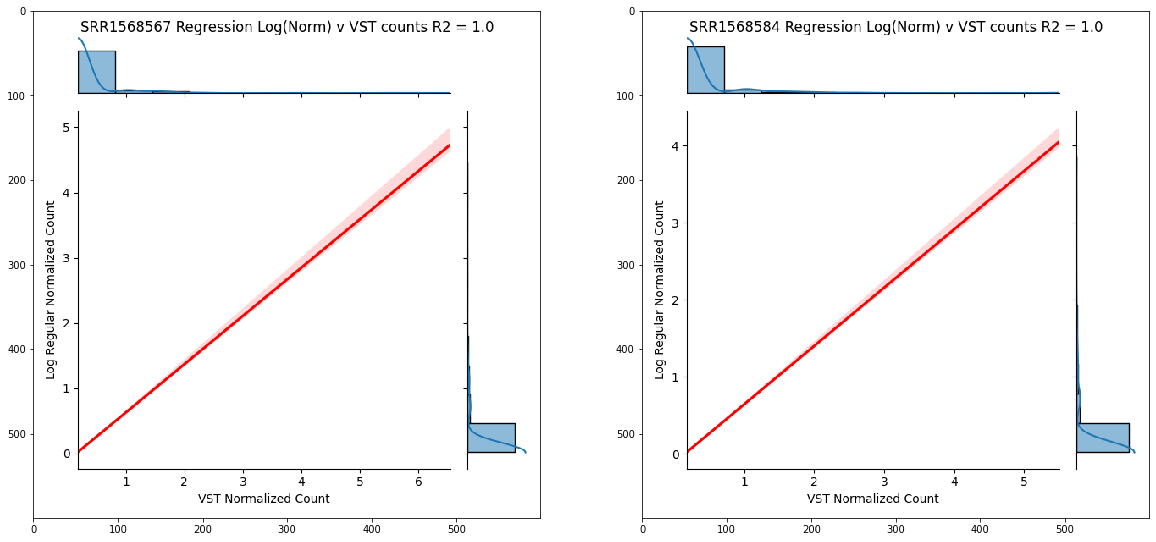

In [5]:
import matplotlib.image as mpimg

img_A = mpimg.imread('../data/out/sra_1.png')
img_B = mpimg.imread('../data/out/sra_2.png')

# display images
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(img_A);
ax[1].imshow(img_B);


### PCA

We performed Principle Component Analysis (PCA) on the VST gene matrix for two PCA Plots, one with the grouping set to disorder, and another plot with the grouping set to biofliud.

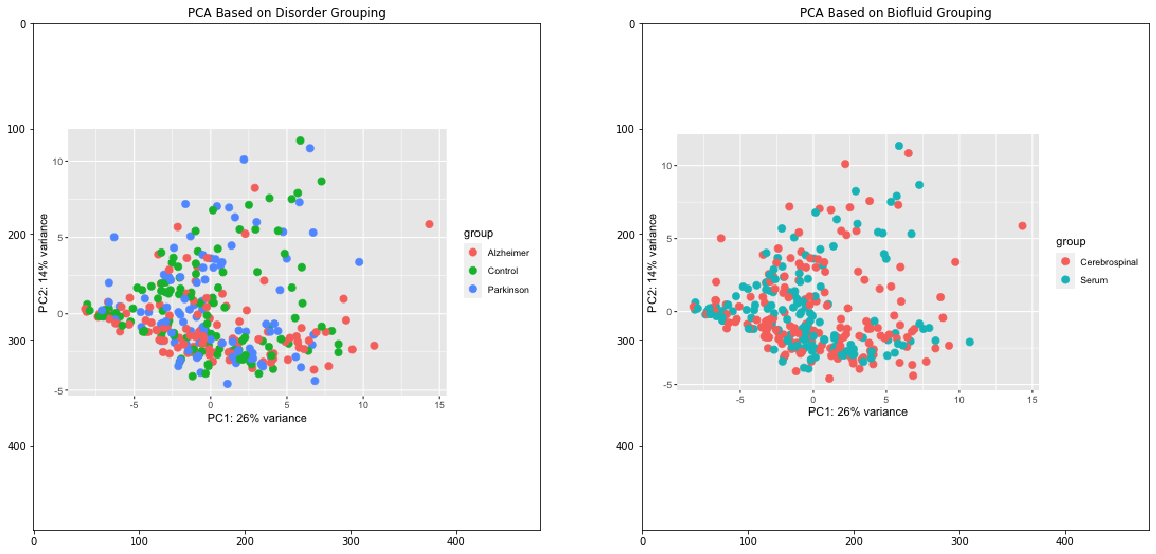

In [6]:
import matplotlib.image as mpimg

img_A = mpimg.imread('../data/out/PCAplot_Disorder.png')
img_B = mpimg.imread('../data/out/PCAplot_Biofluid.png')

# display images
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(img_A);
ax[1].imshow(img_B);

title = ax[0].set_title("PCA Based on Disorder Grouping")
title = ax[1].set_title("PCA Based on Biofluid Grouping")

### Removing Non Varying Genes
The majority of the 180K genes are missing across all samples and are thus not relevant for analysis and comprimise quality and performance of the analysis. We can plot these genes to see the missingness percentage to see if there is a pattern related to the biofluid or gender. The plot below shows the missing genes do not have a pattern in any particular classification of patients.

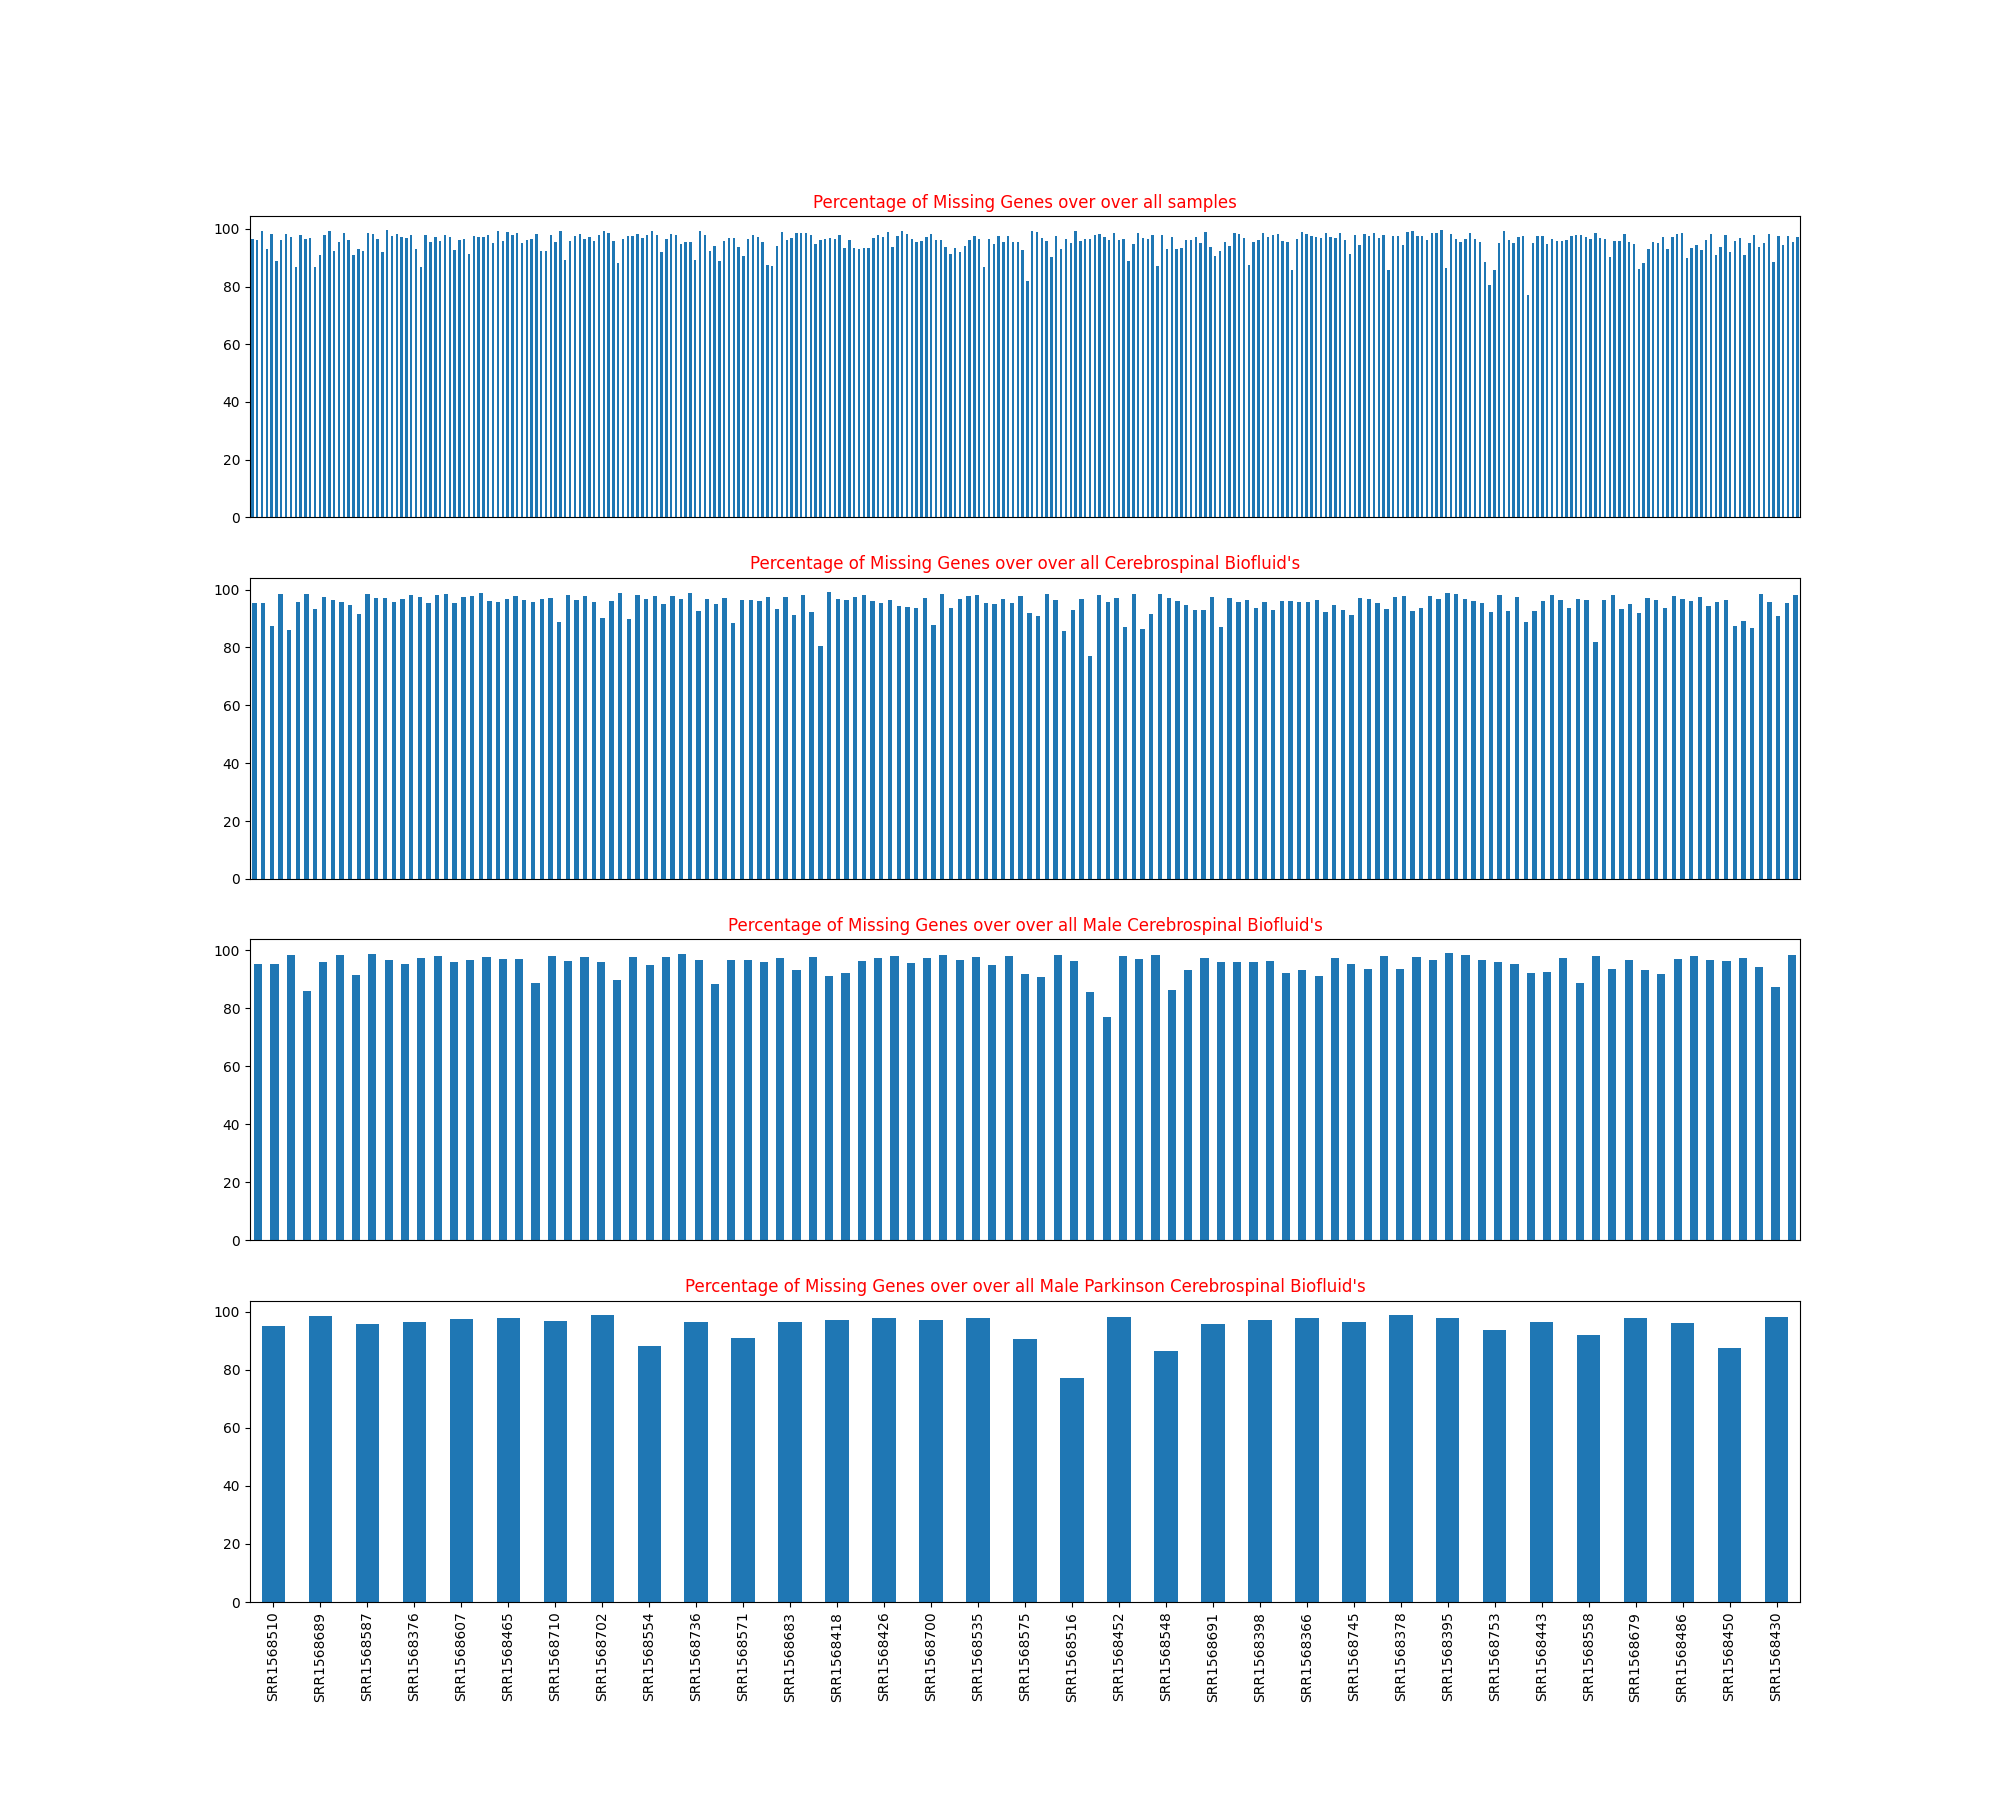

In [7]:
Image("../data/out/missing.png", width=800)

We can identify the top contributing genes by calculating the L1 distance against the mean for each gene across the samples that measures the spread against the mean normalized count. 

In [8]:
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))


df3 = pd.read_csv("../data/out/top_genes.tsv", sep='\t', index_col=0)
df3 = df3.rename({"gene": "Gene"}, axis=1)
df3.Gene = df3.Gene.str.slice(0,10) + ".." + df3.Gene.str.slice(-10,-1)
display_side_by_side([df3.iloc[:3,:], df3.iloc[-3:,:]], ['Top Ranked Genes', 'Bottom Ranked Genes'])

,Gene,Spread
0,crm-miR-23..ei:miR-23,370.834
1,tni-miR-20..s:miR-204,359.091
2,cbn-miR-54..:miR-54-3,345.663
,Gene,Spread
403,efu-miR-21..us:miR-21,1.24867
404,cfa-miR-30..io:miR-30,1.24867
405,ipu-miR-30..us:miR-30,1.24867


### Volcano Plot
 
<span style="color:red"> TODO: explain this </span>

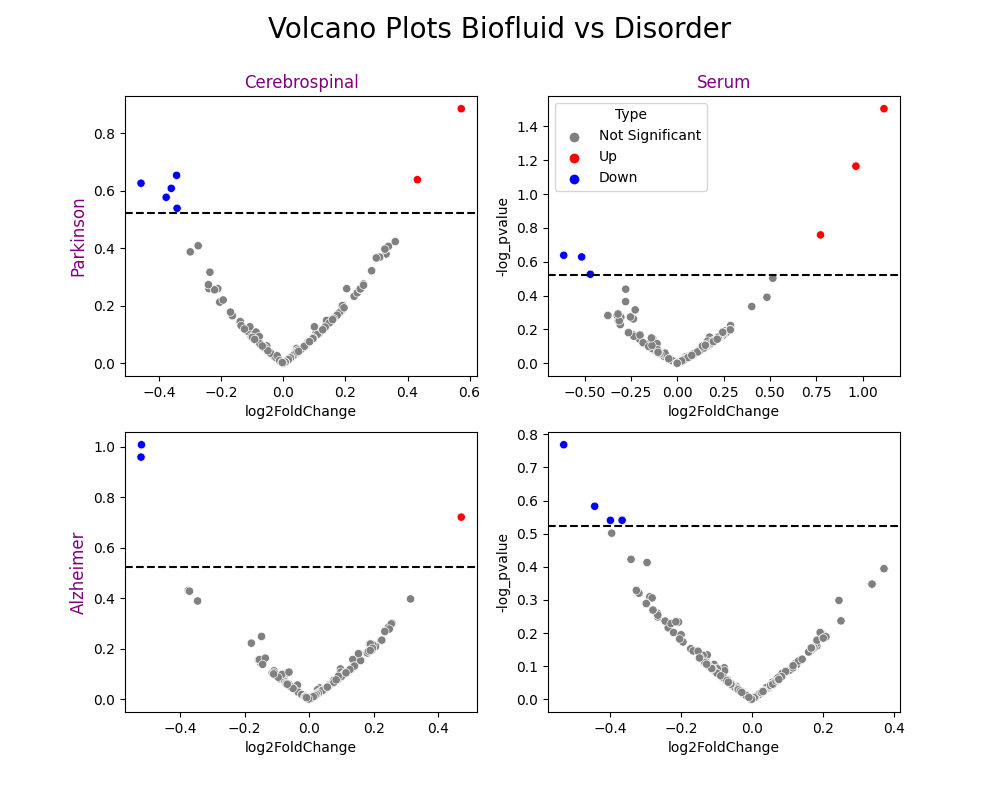

In [9]:
Image("../data/out/volcano.png", width=800)

### MA Plot

The LRT data for each of the 4 comparisons was used to generate a 2x2 MA Plot shown in Figure 16 below. This is a scatter plot of the mean of the normalized counts against the log fold change. There does not appear to be any highly significant patterns as the data points appear to be within the same band. However, the Alzheimers plots for cerbrospinal fluid and serum have a wider x-range up to 2000 compared to Parksinson's 1000 x-axis maximum. This is because of the more abundant outliers that the Alzheimers plots have.

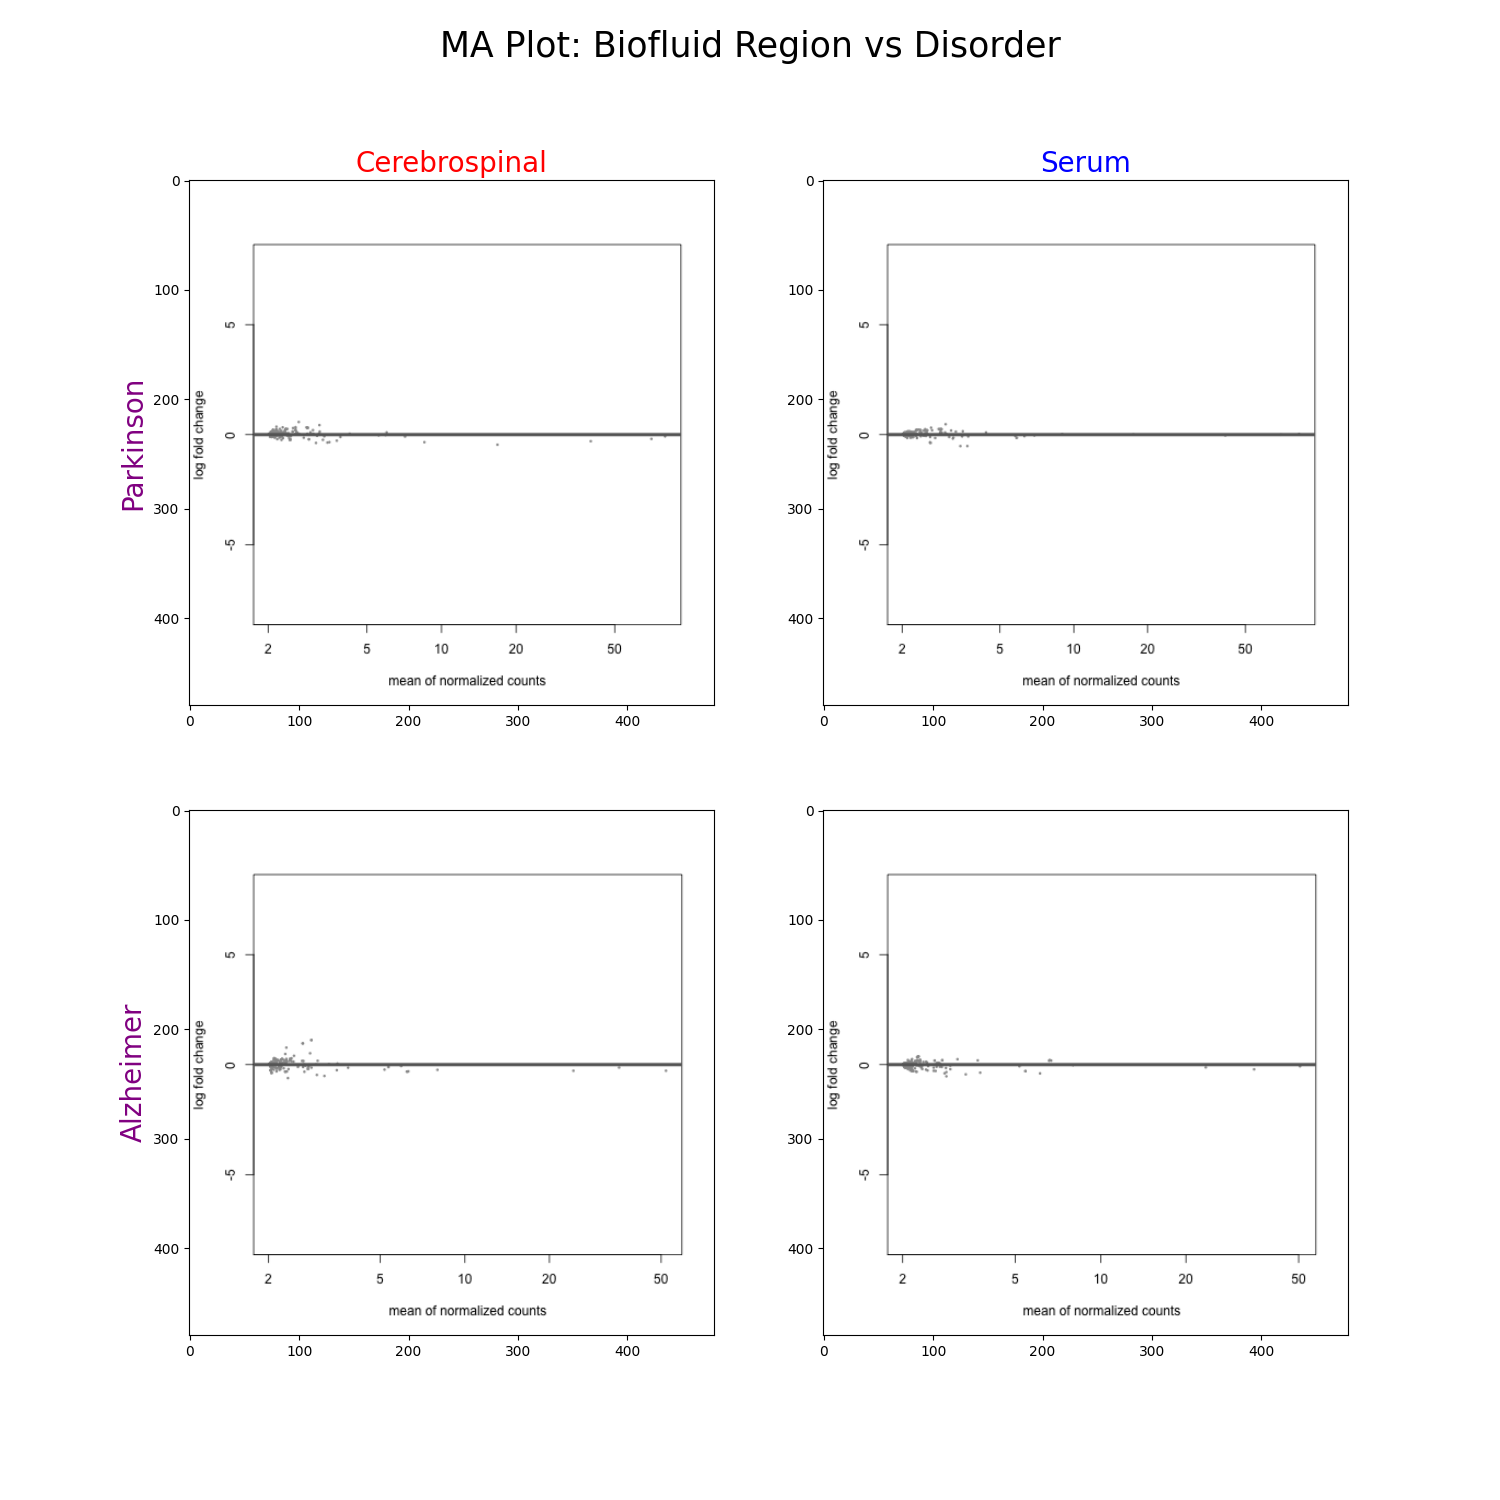

In [10]:
Image("../data/out/ma_plot.png", width=800)

### Heat Maps

The LRT data for each of the 4 analysis regions was used to generate a 2x2 heatmaps of the top 100 genes is shown in Figure 17 below. Heatmaps allow us to observe specific values of interest across two axis variables in the form of a grid with colored cells10. The variables we have used for our axes are the patients and the miRNAs identified across our patient samples, with the main value of interest being the miRNA expression between patients of different disorders. By observing our value of interest, miRNA expression, we can then be able to determine if any patterns or associations exist within our 4 analysis regions. The bottom left chart, cerebrospinal fluid in Alzheimers looks significantly different than the other three charts. In general, the bottom left chart has higher intensity for both sides of the color spectrum highlighted changes in the miRNA expression pattern.

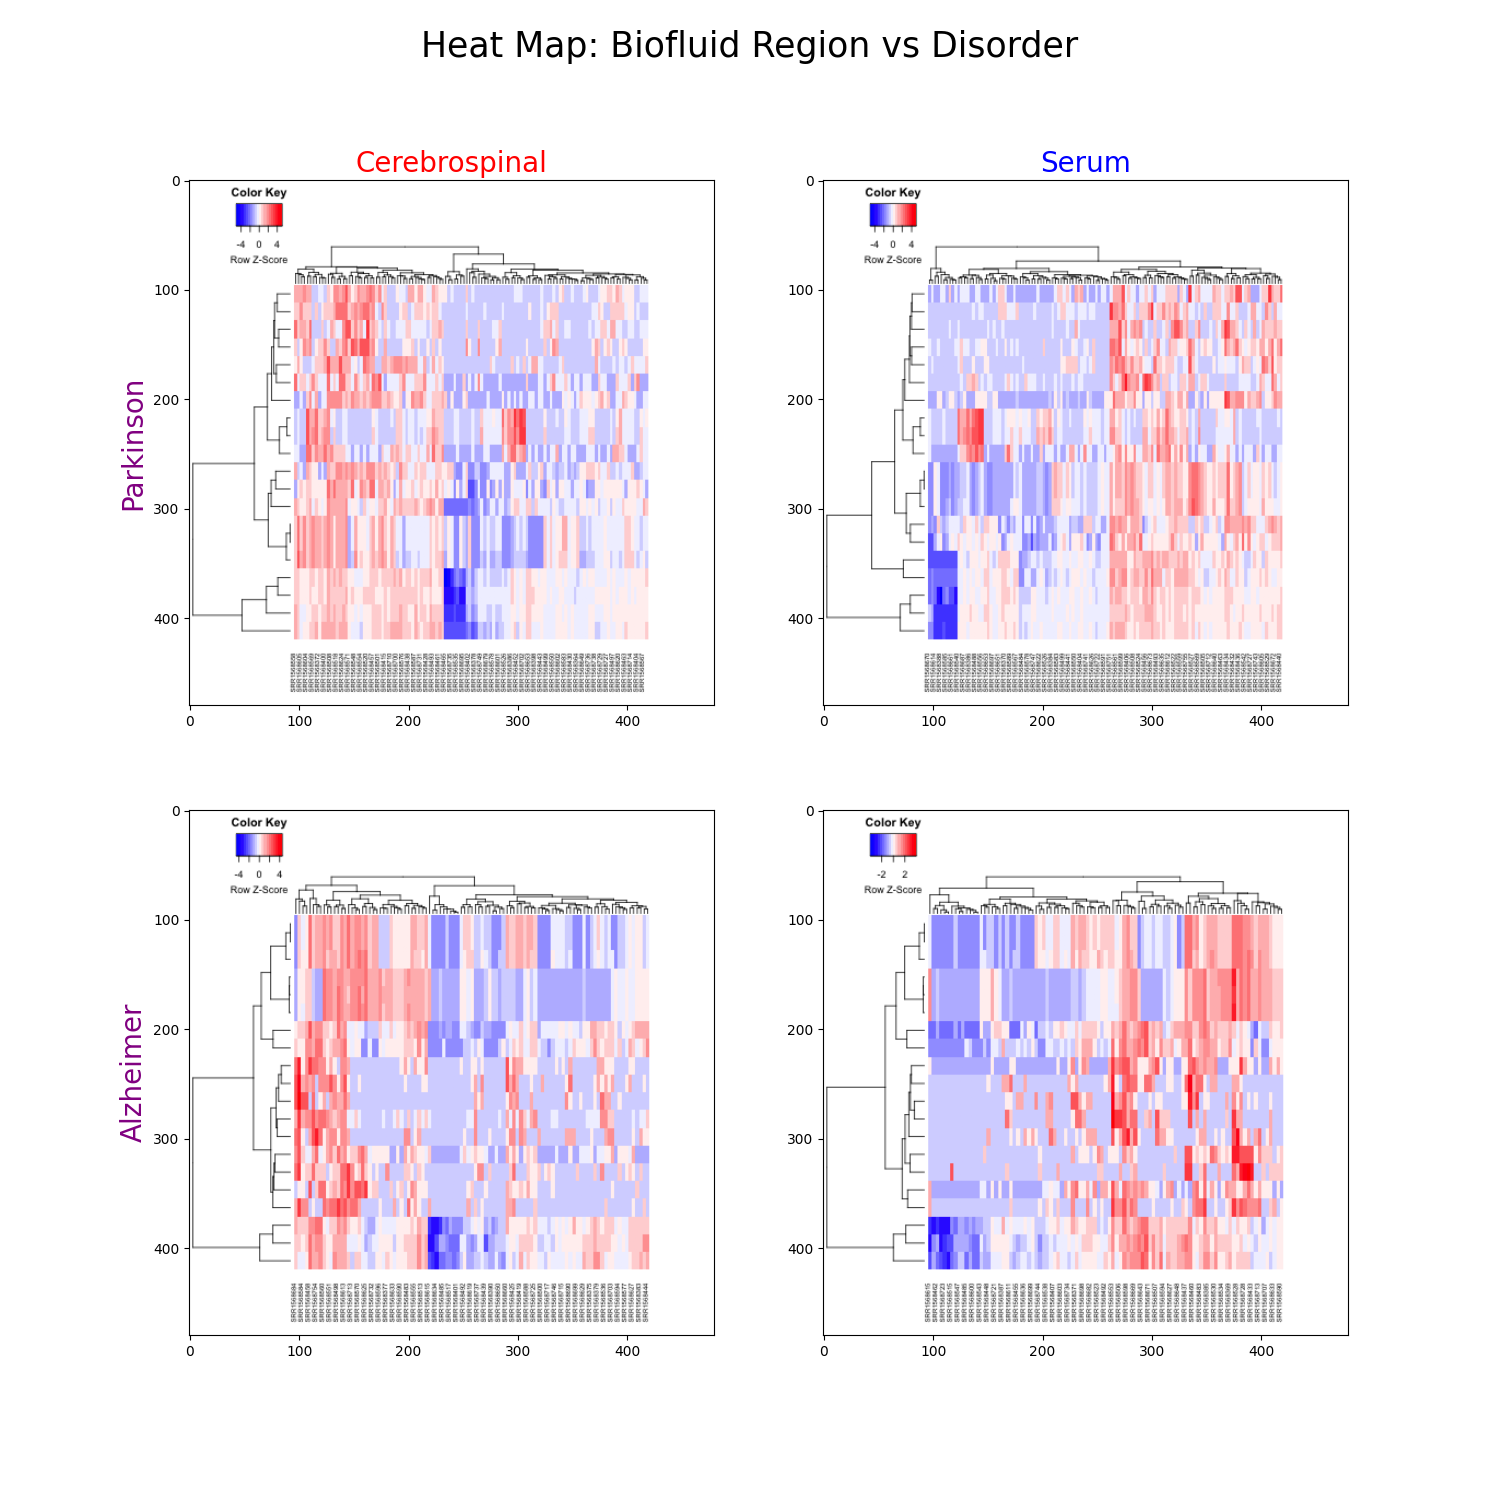

In [11]:
Image("../data/out/heat_map.png", width=800)

### Histograms of case versus control differential expression

We repeat the same visualization in the paper for the distribution of the pvalues for each of the 4 regions shown in Figure 18 below. The top left chart, cerebrospinal vs Parksinson, has its peak at two places, around 0.4 and 0.8. The top right chart, serum vs Parksinson, has its peak at the start at around 0.0 and two other minor peaks at around 0.6 and 0.9. The bottom left chart, cerebrospinal vs Alzheimers, has its peak at around 0.8. Finally the bottom right chart, serum vs Alzheimers, has its peak at three parts around 0.1, 0.5, and 1.0. Intrestingly, the charts for cerebrospinal vs Parkinsons and Alzheimers look similar and the charts for serum vs Parkinsons and Alzheimers are more similar. This is significant to note because rather than the disease being more similar across biofluids, it happens to be that the biofluids are more similar across the two disorders.

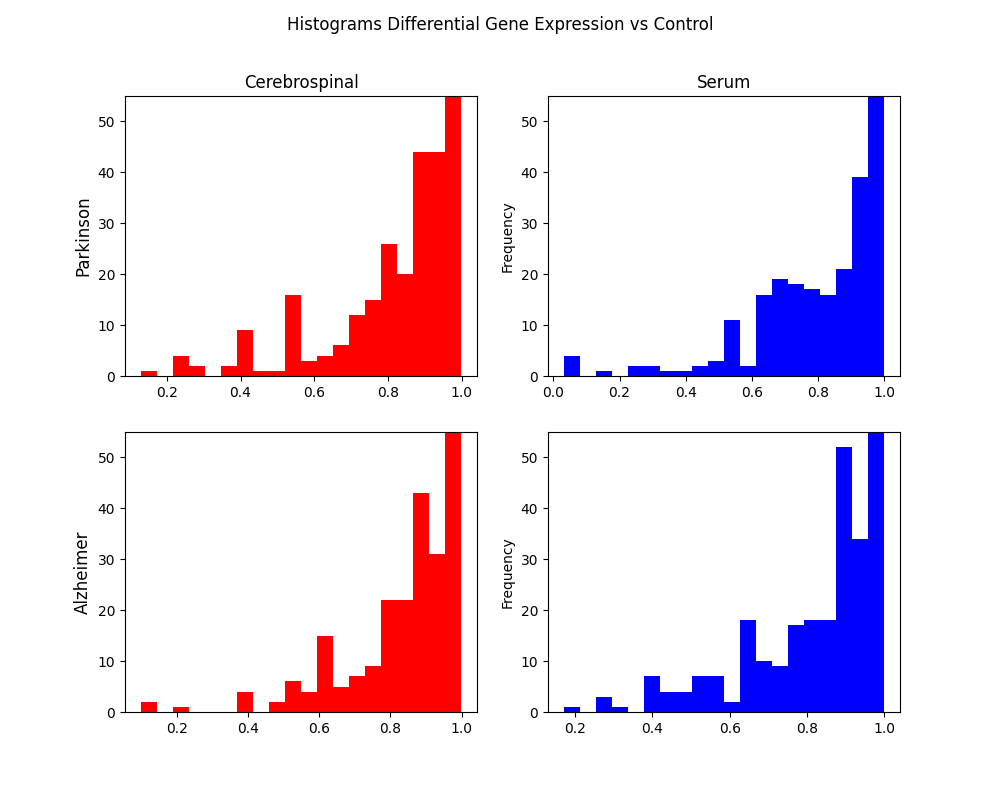

In [12]:
Image("../data/out/histogram.png", width=800)

### Venn Diagram of Disorders 

Another visualization performed is a venn diagram that shows overlap of miRNAs differentially expressed between Parkinson (red) and Alzheimer (green). Majority of miRNAs are in Parksinsons with the number 47. However, only 3 miRNAs are in Alzeihmers only which is a very small amount. But between the two disorders there are 38 miRNAs shared. This indicates that there are many miRNAs between Parkinsons and Alzheimers that are shared.

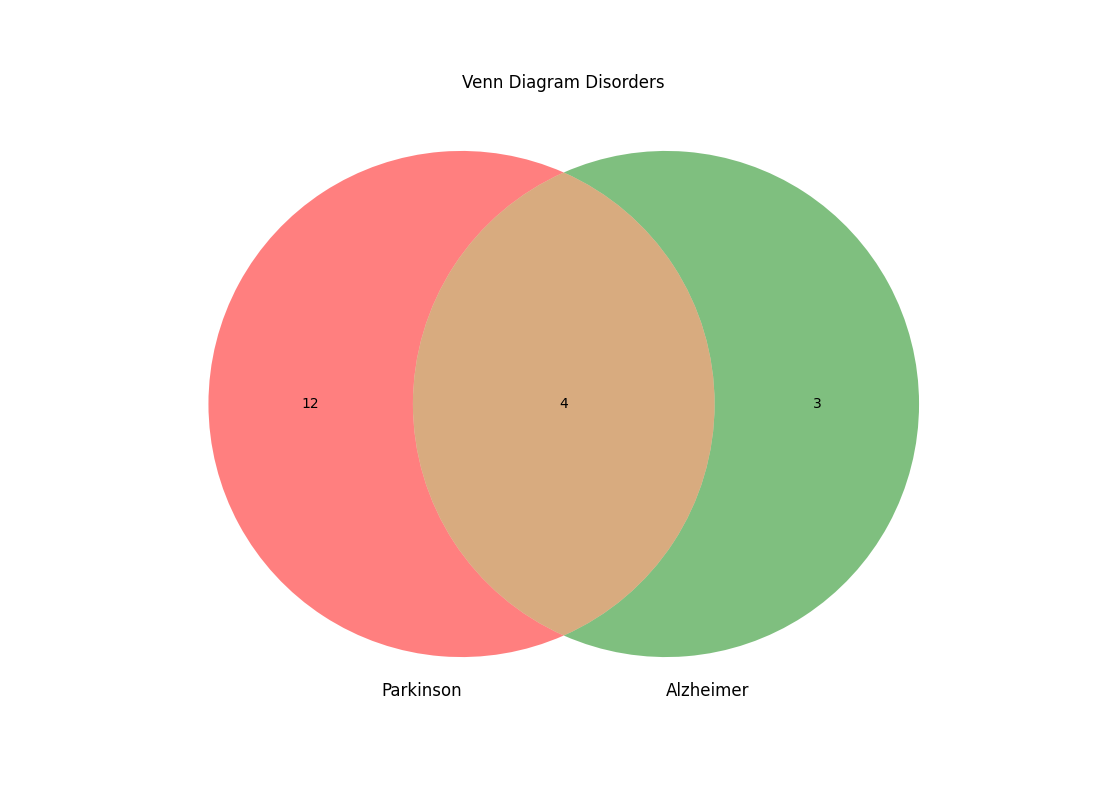

In [13]:
Image("../data/out/venn.png", width=600)

### Spearman correlations of log2 fold gene expression 

We finally recreate the spearman correlation matrix that is pairwise Spearman correlations of log2 fold gene expression changes between each disorder and CTL in each biofluid. The circle sizes are scaled to reflect absolute Spearman correlations. To produce this plot we took the log2 fold gene expressions column from each of the 4 LRT analyses we performed and then use Panda's correlation function to generate a R2 pearson correlation number.
The striking amount of correlation is between Parkinson and Alzheimers in the cerebrospinal fluid region. This is ver important as it implies that there is a significant amount of correlation between the two disorders for this biofluid. There is also more correlation between the two biofluids of Alzheimers compared to Parkinsons.
The results are shown below in Figure 20.

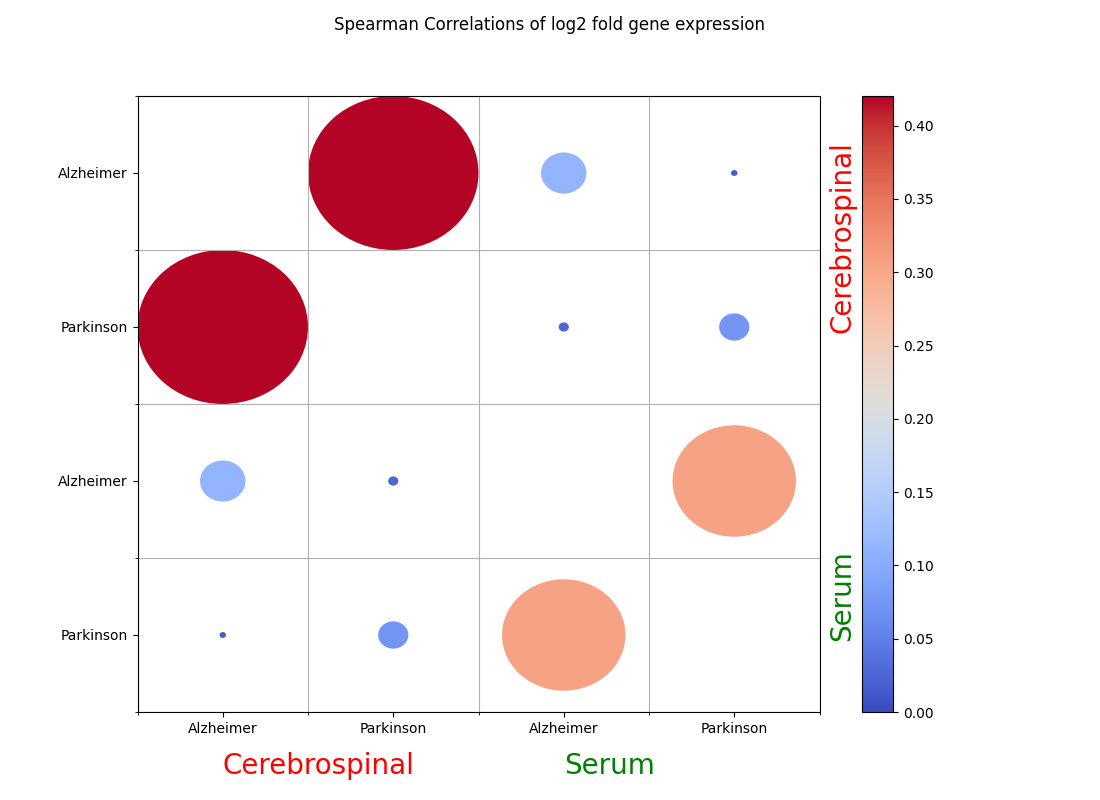

In [14]:
Image("../data/out/corrmatrix.png", width=600)